In [6]:
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
import argparse
from os import path
import time
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
from matplotlib import ticker

In [7]:
# load the data
DF = pd.read_csv("NormalisedSectorReturns.csv", index_col = "Date")
#DF = pd.read_csv("Companies1992_2012.csv",
#                index_col="Date")

In [8]:
# first rows are NaNs because of local renormalisation
print(DF.shape)
DF

(5291, 11)


,Health Care,Information Technology,Communication Services,Consumer Staples,Industrials,Financials,Materials,Energy,Utilities,Consumer Discretionary,Real Estate
Date,,,,,,,,,,,
1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-0.441763,0.670262,-0.398577,-2.270288,0.815300,0.769609,1.531560,0.259590,-0.010367,0.495473,1.825515
2012-12-26,-2.003780,-0.028683,-1.104986,-3.288099,0.322920,0.363189,1.403318,-0.263669,-1.660171,-0.544829,0.937984
2012-12-27,-1.904692,-0.168620,-1.562863,-2.349480,0.150949,-0.153393,0.950021,-0.391250,-1.706122,-0.294891,1.050426


In [9]:
# compute correlation matrices for overlapping, moving intervals
Period = 40 # 2 trading months
Shift = 1
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],
                         DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))
CorrMatricesFull = np.empty((T,int(DF.shape[1]**2.)))

print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    CorrMatricesFull[t,:] = IntervalCorr
    
    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]

CorrMatrices.shape   

(11, 11)
55.0
(1, 121) 55
1


(5251, 55)

### True kmeans-approach

And try to sort the labels according to their first appearance in the data.

In [10]:
KMTrue = KMeans(n_clusters = 8,random_state = 12345).fit(CorrMatrices) 

In [11]:
KMTrue.predict(CorrMatrices)

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [12]:
TimeIndex = DF.index[20:(len(DF.index)-20)]
T = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in TimeIndex]

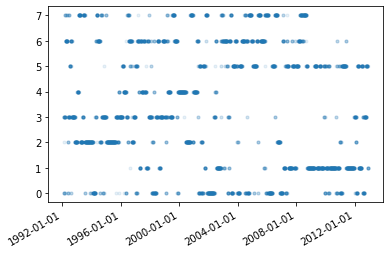

In [13]:
LabelNaive = KMTrue.predict(CorrMatrices)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaive, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [14]:
Indexshift = np.zeros(((max(LabelNaive)+1),2)).astype("int") # keep track of which cluster is assigned which number

Indexshift = pd.DataFrame({"Old Label":[],
                          "New Label":[]})
NewLabel = int(0)
for i in range(len(LabelNaive)):
    if (LabelNaive[i] in set(Indexshift["Old Label"]))==False:
        Indexshift = Indexshift.append(pd.DataFrame({"Old Label":[LabelNaive[i]],
                                                      "New Label":[NewLabel]}), ignore_index=True)
        NewLabel = int(NewLabel+1)
print(Indexshift)

   Old Label  New Label
0        0.0        0.0
1        2.0        1.0
2        3.0        2.0
3        7.0        3.0
4        6.0        4.0
5        5.0        5.0
6        4.0        6.0
7        1.0        7.0


/tmp/ipykernel_1307460/2124412169.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Indexshift = Indexshift.append(pd.DataFrame({"Old Label":[LabelNaive[i]],


In [15]:
LabelNaiveOrdered = np.empty(len(LabelNaive))

for i in range(len(LabelNaive)):
    LabelNaiveOrdered[i] = int(Indexshift.loc[Indexshift["Old Label"]==LabelNaive[i]]["New Label"])

CentroidsNaive = np.zeros((max(LabelNaive)+1, CorrMatrices.shape[1]))

for j in range(max(LabelNaive)+1): # go through the new orering of the clusters
    Old_Order = int(Indexshift.loc[Indexshift["New Label"]==j]["Old Label"])
    CentroidsNaive[j] = KMTrue.cluster_centers_[Old_Order]

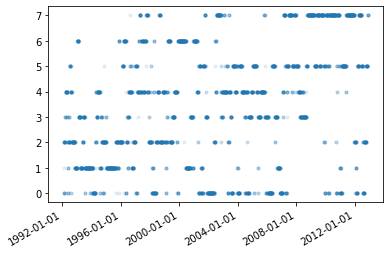

In [16]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaiveOrdered,
         ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [17]:
Indexshift["Old Label"][0]

0.0

In [18]:
for i in range(CentroidsNaive.shape[0]):
    print(sum(KMTrue.cluster_centers_[int(Indexshift["Old Label"][i])]  != CentroidsNaive[i]  ))
#print(KMTrue.cluster_centers_[6])

0
0
0
0
0
0
0
0


In [21]:
print(DF.columns)
# E: Energy, CD: Constumer Discretionary, F: Financials, I: Industrials, U: Utilities, CS: Constumer Staples,
# RE: Real Estate, Com: Communication Services, M: Materials, IT: Information Technology
Names = ["HC", "IT", "Com", "CS", "I", "F", "M", "E", "U", "CD", "RE"]

Index(['Health Care', 'Information Technology', 'Communication Services',
       'Consumer Staples', 'Industrials', 'Financials', 'Materials', 'Energy',
       'Utilities', 'Consumer Discretionary', 'Real Estate'],
      dtype='object')


In [22]:
CorrMatrices.shape
np.save("CorrMatricesTriangular", CorrMatrices)

np.save("LabelNaiveOrdered",
       LabelNaiveOrdered)
np.save("Names", Names)

## Neuralising kmeans

In [23]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)

def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )


def DecisionLayer(Minimum):
    return(Minimum > 0)



def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [24]:
# Do this for the naive kmeans

nKM = max(LabelNaive) + 1 
print(nKM)


# CHeck for all instances
Layer_Pred2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred2)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],KMTrue.cluster_centers_, j))    
        if Decision:
            Layer_Pred2[i] = range(nKM)[j]
            
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, LabelNaive[i], Layer_Pred2[i])
print("Should be zero:", sum(Layer_Pred2 != LabelNaive))
# So this actually works!!!

8
Should be zero: 0


### LRP Functions

In [25]:
def beta(X, i, DecisionL, NN, Centroids):
    # Takes the Data X, a particular class i, a Decision Layer DecisionL and Neuralised kmeans NN = NN(x,centroids,k)
    # Returns the beta-scaling factor from eq. (3)
    IS_i = np.empty(X.shape[0])
    
    for j in range(X.shape[0]):
        IS_i[j] = NN(X[j,:],
                     Centroids,
                     i)
    return( np.mean(IS_i)**(-1.))
    

In [26]:


def Eq2(X, Centroids, c, beta):
    # take one Data.point X, the cluster Centroids and the cluster of interest c, scaling factor beta
    # output: R_k - array as in equation (2)
    
    n_C = Centroids.shape[0]
    
    H_k = layer1(X, Centroids, c)
    F_c = layer2(H_k, c)
    
    # numerator of eq. (2)
    r_k_func = np.exp(-beta * H_k) * F_c
    
    R_k_out = r_k_func / sum(r_k_func[np.arange(n_C) != c])
    #print(range(n_C), range(n_C) != c)
    return(R_k_out)

In [27]:
def Eq4(X, Centroids, c, beta):

    n_C = Centroids.shape[0]
    Index = (np.arange(n_C) != c) # index of "all clusters except c"
    
    R_previous = Eq2(X, Centroids, c, beta) # from Equation (2)
    R_previous_reduced = R_previous[Index]
    MU_c = Centroids[c]
    M_k = 0.5*(Centroids + MU_c)
    DIFF_x_m = X - M_k
    
    DIFF_x_m_reduced = DIFF_x_m[Index]
    
    W = 2*(MU_c - Centroids)
    W_reduced = W[Index]
    
    Prod = np.multiply(DIFF_x_m_reduced, W_reduced)
    
    R_InputLayer = np.zeros(len(X)) # relevance of each input-feature
    
    for i in range(len(R_InputLayer)):
        for k in range(n_C-1):
            R_InputLayer[i] += Prod[k,i] * R_previous_reduced[k] / np.sum(Prod[k,:])
    
    return(R_InputLayer)

In [28]:

def xai_clust(X, Centroids, X_Label, Dat, DecisionL, Neuralised):

    return(Eq4(X, Centroids,  X_Label,
           beta(Dat, X_Label, DecisionL, Neuralised, Centroids)))


In [29]:
xai_clust(CorrMatrices[0,:], 
          CentroidsNaive, 0, CorrMatrices, 
          DecisionLayer, NN_k).round(1)

array([ 0. ,  0. , -0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
       -0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0. ,  0. , -0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. , -0. ,  0.1,  0. ,  0.1,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0. ,  0. ,  0. ,
        0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0. ])

## Go through entire Data

In [30]:
XAI = np.zeros(CorrMatrices.shape)
LabelNaiveOrdered # is the ordered label output

for i in range(CorrMatrices.shape[0]):
    x = CorrMatrices[i,:]
    XAI[i,:] = xai_clust(x, CentroidsNaive, 
                         LabelNaiveOrdered.astype("int")[i],
                         CorrMatrices, DecisionLayer, NN_k)
print(XAI.round(1))


[[ 0.  0. -0. ...  0.  0. -0.]
 [ 0.  0. -0. ...  0.  0. -0.]
 [ 0.  0. -0. ...  0.  0. -0.]
 ...
 [ 0.  0.  0. ... -0.  0. -0.]
 [ 0.  0.  0. ... -0.  0. -0.]
 [ 0.  0.  0. ... -0.  0. -0.]]


In [38]:
np.save("XAI_Finance",XAI)

Cluster 0 with centroid [0.39 0.35 0.4  0.49 0.41 0.36 0.28 0.32 0.32 0.32 0.58 0.09 0.54 0.3
 0.43 0.35 0.21 0.28 0.31 0.19 0.51 0.39 0.45 0.35 0.22 0.23 0.26 0.38
 0.35 0.28 0.03 0.28 0.36 0.34 0.57 0.63 0.4  0.28 0.43 0.4  0.39 0.14
 0.23 0.25 0.28 0.44 0.2  0.36 0.37 0.3  0.23 0.1  0.22 0.29 0.26]
And mean importances [0.01 0.02 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.03 0.01 0.02
 0.03 0.03 0.03 0.02 0.01 0.03 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.01
 0.02 0.02 0.04 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.01 0.01 0.02 0.03
 0.02 0.03 0.02 0.02 0.02 0.02 0.02 0.01 0.02 0.03 0.02 0.01 0.02]


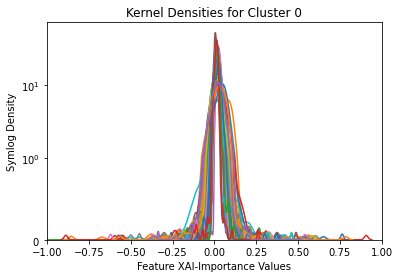

Cluster 1 with centroid [ 0.33  0.26  0.34  0.21  0.14  0.15 -0.02  0.02  0.32  0.05  0.27  0.07
  0.42  0.11  0.2   0.08 -0.1   0.32  0.2   0.32  0.23  0.26  0.1   0.1
  0.15  0.21  0.02  0.2   0.25  0.09  0.01  0.14  0.27  0.09  0.36  0.39
  0.22  0.12  0.42  0.35  0.06 -0.02  0.35  0.36  0.28  0.17  0.02  0.19
  0.25  0.14  0.11  0.09  0.13  0.12  0.31]
And mean importances [ 0.01  0.02  0.01  0.01  0.05  0.02  0.    0.06  0.01  0.04  0.01  0.02
  0.01  0.03  0.03  0.02  0.03  0.01  0.01  0.02  0.01  0.02  0.    0.03
  0.01  0.01  0.01  0.01  0.02  0.    0.02  0.03  0.01  0.01  0.02  0.01
  0.02  0.03  0.01  0.01  0.06  0.03 -0.    0.01  0.01  0.03  0.03  0.01
  0.01  0.02  0.02  0.02  0.01  0.02  0.01]


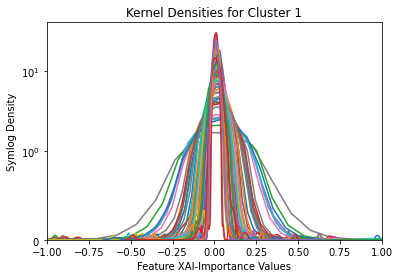

Cluster 2 with centroid [ 0.59  0.52  0.54  0.62  0.52  0.49  0.4   0.04  0.62  0.39  0.58  0.35
  0.61  0.44  0.51  0.41 -0.07  0.59  0.35  0.47  0.62  0.53  0.49  0.39
  0.17  0.56  0.33  0.55  0.49  0.4   0.31  0.21  0.52  0.26  0.64  0.69
  0.54  0.02  0.7   0.46  0.47  0.43  0.14  0.55  0.34  0.5   0.04  0.51
  0.49  0.05  0.41  0.35 -0.05  0.15  0.37]
And mean importances [0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.04 0.02 0.01 0.01 0.02 0.02 0.02
 0.03 0.03 0.05 0.02 0.02 0.01 0.01 0.01 0.02 0.03 0.02 0.02 0.02 0.01
 0.01 0.02 0.03 0.02 0.01 0.02 0.01 0.01 0.02 0.04 0.01 0.01 0.02 0.03
 0.02 0.01 0.01 0.01 0.04 0.01 0.01 0.03 0.02 0.02 0.03 0.02 0.01]


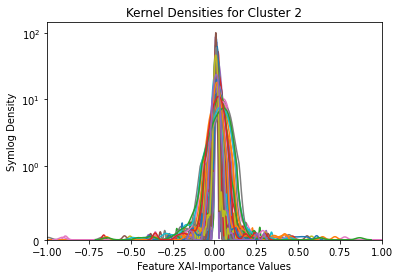

Cluster 3 with centroid [ 0.59  0.54  0.54  0.61  0.57  0.38 -0.12  0.07  0.52  0.41  0.61  0.49
  0.63  0.5   0.43  0.01  0.11  0.54  0.45  0.46  0.6   0.53  0.38 -0.04
  0.09  0.5   0.43  0.62  0.49  0.33 -0.15  0.22  0.46  0.42  0.66  0.58
  0.01  0.21  0.61  0.54  0.39 -0.11  0.13  0.54  0.42  0.21  0.24  0.4
  0.47  0.27 -0.02 -0.03  0.1   0.17  0.45]
And mean importances [0.01 0.01 0.01 0.01 0.01 0.01 0.06 0.03 0.01 0.01 0.01 0.03 0.01 0.02
 0.02 0.05 0.03 0.02 0.01 0.01 0.01 0.01 0.02 0.05 0.02 0.01 0.01 0.01
 0.01 0.01 0.05 0.02 0.01 0.01 0.01 0.01 0.06 0.02 0.   0.01 0.02 0.07
 0.02 0.01 0.01 0.03 0.02 0.01 0.01 0.01 0.03 0.03 0.01 0.01 0.01]


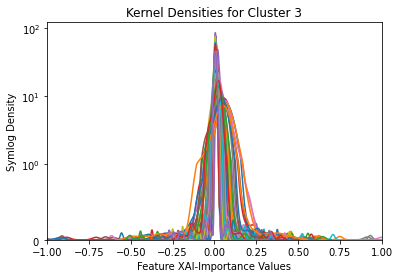

Cluster 4 with centroid [0.62 0.6  0.71 0.76 0.66 0.63 0.3  0.52 0.64 0.56 0.59 0.51 0.66 0.55
 0.56 0.2  0.44 0.55 0.52 0.6  0.7  0.67 0.58 0.23 0.44 0.55 0.45 0.77
 0.7  0.62 0.23 0.53 0.64 0.54 0.77 0.77 0.35 0.58 0.71 0.66 0.63 0.23
 0.51 0.6  0.54 0.4  0.53 0.63 0.6  0.33 0.23 0.26 0.46 0.47 0.59]
And mean importances [0.01 0.01 0.02 0.03 0.02 0.02 0.01 0.03 0.02 0.02 0.01 0.03 0.02 0.02
 0.03 0.02 0.03 0.02 0.02 0.01 0.02 0.01 0.03 0.02 0.02 0.01 0.02 0.03
 0.02 0.03 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.03 0.01 0.01 0.02 0.02
 0.01 0.01 0.01 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.03 0.01 0.01]


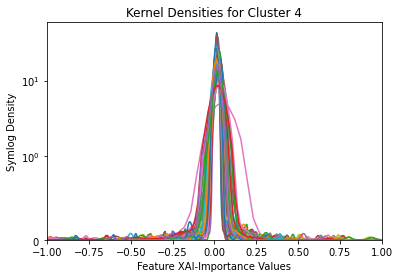

Cluster 5 with centroid [0.59 0.6  0.65 0.59 0.55 0.56 0.45 0.57 0.38 0.49 0.71 0.54 0.78 0.57
 0.67 0.54 0.46 0.43 0.52 0.58 0.71 0.62 0.65 0.56 0.56 0.38 0.53 0.59
 0.52 0.58 0.46 0.54 0.41 0.47 0.68 0.81 0.58 0.48 0.51 0.61 0.56 0.44
 0.45 0.43 0.55 0.64 0.46 0.47 0.57 0.45 0.28 0.41 0.32 0.43 0.46]
And mean importances [0.01 0.01 0.01 0.01 0.01 0.02 0.03 0.04 0.01 0.02 0.02 0.03 0.03 0.03
 0.04 0.04 0.04 0.01 0.02 0.01 0.02 0.01 0.03 0.04 0.03 0.01 0.02 0.01
 0.01 0.02 0.03 0.02 0.01 0.01 0.01 0.01 0.02 0.02 0.01 0.01 0.02 0.03
 0.01 0.01 0.01 0.02 0.02 0.01 0.01 0.02 0.01 0.02 0.01 0.01 0.01]


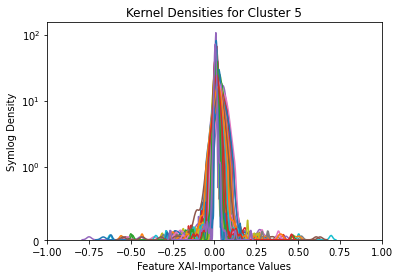

Cluster 6 with centroid [ 0.23  0.3   0.42  0.44  0.45  0.21  0.31  0.24  0.4   0.3   0.29 -0.06
  0.11  0.   -0.15 -0.05 -0.2   0.05  0.    0.37  0.4   0.44  0.09  0.06
  0.07  0.37  0.13  0.59  0.63  0.46  0.28  0.5   0.58  0.45  0.68  0.58
  0.33  0.37  0.69  0.55  0.41  0.33  0.43  0.57  0.42  0.38  0.28  0.58
  0.6   0.29  0.38  0.31  0.26  0.33  0.53]
And mean importances [0.04 0.01 0.   0.   0.01 0.02 0.02 0.01 0.   0.01 0.03 0.05 0.06 0.06
 0.07 0.03 0.05 0.04 0.03 0.01 0.01 0.01 0.04 0.02 0.01 0.01 0.02 0.01
 0.01 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


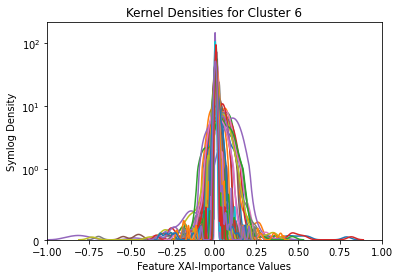

Cluster 7 with centroid [0.78 0.76 0.75 0.82 0.78 0.79 0.71 0.7  0.7  0.72 0.83 0.7  0.88 0.8
 0.86 0.76 0.65 0.74 0.71 0.73 0.84 0.79 0.81 0.75 0.67 0.71 0.7  0.75
 0.7  0.74 0.67 0.68 0.67 0.66 0.86 0.92 0.81 0.69 0.8  0.76 0.83 0.74
 0.66 0.75 0.77 0.8  0.67 0.78 0.78 0.66 0.66 0.67 0.59 0.65 0.69]
And mean importances [0.01 0.01 0.01 0.01 0.02 0.02 0.03 0.03 0.01 0.02 0.01 0.03 0.02 0.03
 0.03 0.04 0.04 0.02 0.02 0.01 0.01 0.01 0.02 0.03 0.02 0.01 0.02 0.01
 0.01 0.02 0.03 0.01 0.01 0.01 0.01 0.01 0.03 0.02 0.01 0.01 0.02 0.03
 0.01 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.02 0.02 0.02 0.01 0.01]


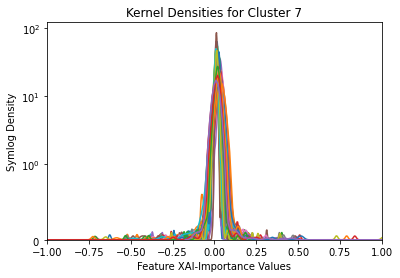

In [31]:
import warnings
warnings.filterwarnings("ignore")

for i in range(nKM):
    print("Cluster", i, "with centroid", CentroidsNaive[i].round(2))
    print("And mean importances", XAI[LabelNaiveOrdered==i,:].mean(0).round(2))
    plt.yscale("symlog", linthresh=1)

    for j in range(min(CorrMatrices.shape[1],100)):
        sns.kdeplot(XAI[LabelNaiveOrdered==i,j], label="Feature " +str(j))
    plt.xlim([-1, 1])
    plt.title("Kernel Densities for Cluster "+str(i))
    plt.ylabel("Symlog Density")
    plt.xlabel("Feature XAI-Importance Values")
    #plt.legend()
    plt.show()

In [32]:
for i in range(nKM):
    print(max(XAI[LabelNaiveOrdered==i,:].mean(0)))

0.03844479061475759
0.060028660293467526
0.05193161079169082
0.07036947532110498
0.03411672463099641
0.044929803925127125
0.07473241668348708
0.03648850544624911


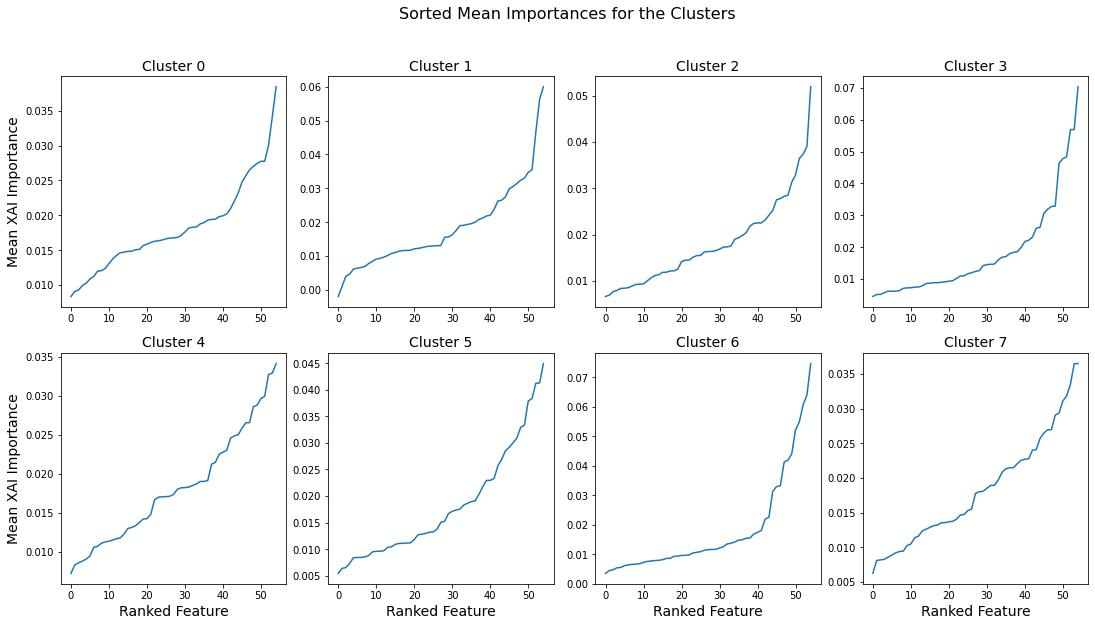

In [33]:
fig, axs = plt.subplots(2, 4,figsize=(15,8))
fig.suptitle("Sorted Mean Importances for the Clusters", fontsize = 16,y=1.05)
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

axs[0,0].set_ylabel("Mean XAI Importance", fontsize=14)
axs[1,0].set_ylabel("Mean XAI Importance", fontsize=14)

for i in range(4):
    axs[0,i].set_title("Cluster "+ str(i), fontsize=14)
    axs[0,i].plot(np.sort(XAI[LabelNaiveOrdered==i,:].mean(0)))
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)

for i in range(4):
    axs[1,i].set_title("Cluster "+ str(i+4), fontsize=14)
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)
    axs[1,i].plot(np.sort(XAI[LabelNaiveOrdered==i+4,:].mean(0)))
plt.show()    

At least for some clusters, one can clearly see an elbow-curve-behaviour at the left and/or right extremes of the feature ranking.

## Now aggregated across all clusters

Text(0.5, 0, 'Sorted Features')

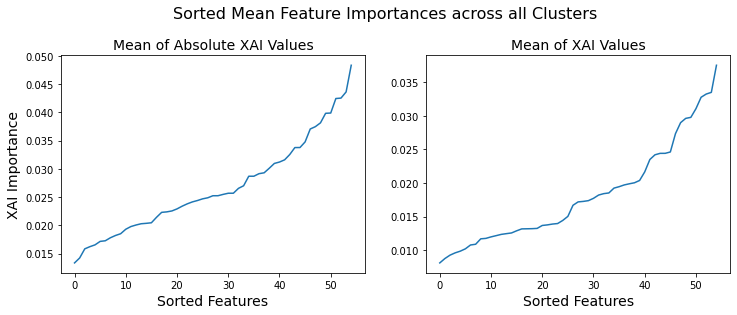

In [34]:
f, ax = plt.subplots( 1,2,figsize=(12,4))
f.suptitle("Sorted Mean Feature Importances across all Clusters", fontsize = 16,y=1.05)

ax[0].set_ylabel("XAI Importance", fontsize=14)

ax[0].set_title("Mean of Absolute XAI Values", fontsize=14)
ax[0].plot(np.sort(abs(XAI).mean(0)))
ax[0].set_xlabel("Sorted Features", fontsize=14)

ax[1].set_title("Mean of XAI Values", fontsize=14)
ax[1].plot(np.sort(XAI.mean(0)))
ax[1].set_xlabel("Sorted Features", fontsize=14)


These are some interesting plots and also show elbow curves for the means. The means of absolute values are less clear to interpret as a sigmoid/elbos

## Export some Plots

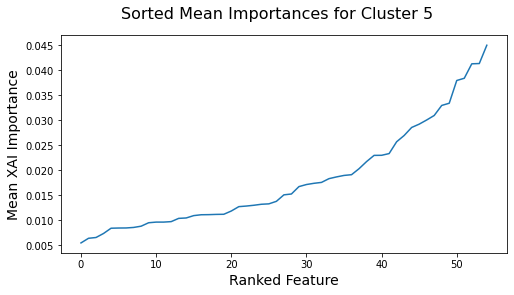

In [35]:
j = 5

fig, axs = plt.subplots(1, 1,figsize=(8,4))
fig.suptitle("Sorted Mean Importances for Cluster "+str(j), fontsize = 16)
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.2)

#axs,set_title("Sorted Mean Importances for Cluster 2")
axs.set_ylabel("Mean XAI Importance", fontsize=14)
axs.plot(np.sort(XAI[LabelNaiveOrdered==j,:].mean(0)))
axs.set_xlabel('Ranked Feature', fontsize=14)
fig.savefig("XAI_Cluster"+str(j)+".png",  dpi=800)

In [36]:
# Export the corresponding data
np.save("XAI_Data_Cluster5.npy",
        XAI[LabelNaiveOrdered==j,:].mean(0))

## Detecting the Elbow

Use a linear interpolation before the elbow or at the centre of the curve. Then, assume that the elbow is at the consecutively n last ranked instances for which the XAI-value is above 3*sigma + linear regression.

In [37]:

def DetectElbow(Data, lower, upper, Deviation = 3, plot = False):
    # Input: Data and a lower/upper index for the range to use for linear interpolation
    # output: The index I for which all Data[-i:-1] are clearly above the linear regression
    #         i.e. the elbow starts at Data[-i]
    #         and all Features which are deemed relevant
    
    Index = np.argsort(Data)
    Sorted = np.sort(Data)
    LR = linregress(np.arange(lower, upper),
                   Sorted[lower:upper])
    
    residua = Sorted - (LR.intercept + LR.slope * np.arange(len(Data)))
    
    Output = None
    RelevantIndex = None
    if residua[-1] > Deviation* LR.stderr:
        Check = True
        i = 1
        while Check:
            i+=1
            Check = (residua[len(residua)-i] > Deviation*LR.stderr)
        Output = i
        RelevantIndex = Index[len(Index)-i+1:] # last i Index values, i,e. highest values
    
    if plot:
            plt.plot(Sorted)
            plt.plot(LR.intercept + LR.slope * np.arange(len(Data)))
            plt.axvline(len(residua)-i,
                       c="red")
            plt.show()
    
    return([Output-1, RelevantIndex])

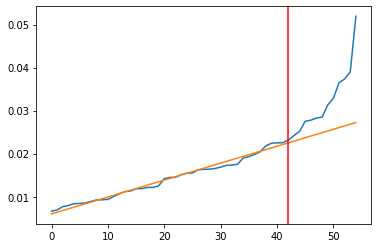

[12, array([11, 23, 49, 15, 14, 30, 52, 41, 46,  7, 37, 16])]

In [39]:
DetectElbow(XAI[LabelNaiveOrdered==2,:].mean(0), 0, 45, 100, True)

In [40]:
AllRelevant = np.array([])

for j in range(nKM):
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, False)
    print(j, DE)
    AllRelevant=np.concatenate([AllRelevant,DE[1]])
print(AllRelevant)

0 [10, array([23, 15, 14, 51, 43, 19, 16, 41, 11, 30])]
1 [10, array([31, 16, 46, 45, 37, 41,  9,  4, 40,  7])]
2 [10, array([49, 15, 14, 30, 52, 41, 46,  7, 37, 16])]
3 [10, array([11,  7, 51, 50, 15, 23, 30,  6, 36, 41])]
4 [7, array([27,  3, 11, 14, 37,  7, 16])]
5 [11, array([13, 11, 41, 22, 30, 24, 23, 14,  7, 15, 16])]
6 [11, array([10, 15, 18, 22,  0, 17, 11, 16, 13, 12, 14])]
7 [7, array([ 6, 13, 23, 41, 14, 16, 15])]
[23. 15. 14. 51. 43. 19. 16. 41. 11. 30. 31. 16. 46. 45. 37. 41.  9.  4.
 40.  7. 49. 15. 14. 30. 52. 41. 46.  7. 37. 16. 11.  7. 51. 50. 15. 23.
 30.  6. 36. 41. 27.  3. 11. 14. 37.  7. 16. 13. 11. 41. 22. 30. 24. 23.
 14.  7. 15. 16. 10. 15. 18. 22.  0. 17. 11. 16. 13. 12. 14.  6. 13. 23.
 41. 14. 16. 15.]


In [41]:
np.array(np.unique(AllRelevant, return_counts=True)).T

array([[ 0.,  1.],
       [ 3.,  1.],
       [ 4.,  1.],
       [ 6.,  2.],
       [ 7.,  5.],
       [ 9.,  1.],
       [10.,  1.],
       [11.,  5.],
       [12.,  1.],
       [13.,  3.],
       [14.,  6.],
       [15.,  6.],
       [16.,  7.],
       [17.,  1.],
       [18.,  1.],
       [19.,  1.],
       [22.,  2.],
       [23.,  4.],
       [24.,  1.],
       [27.,  1.],
       [30.,  4.],
       [31.,  1.],
       [36.,  1.],
       [37.,  3.],
       [40.,  1.],
       [41.,  6.],
       [43.,  1.],
       [45.,  1.],
       [46.,  2.],
       [49.,  1.],
       [50.,  1.],
       [51.,  2.],
       [52.,  1.]])

(array([1., 0., 0., 1., 1., 0., 2., 5., 0., 1., 1., 5., 1., 3., 6., 6., 7.,
        1., 1., 1., 0., 0., 2., 4., 1., 0., 0., 1., 0., 0., 4., 1., 0., 0.,
        0., 0., 1., 3., 0., 0., 1., 6., 0., 1., 0., 1., 2., 0., 0., 1., 1.,
        2.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
        43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5]),
 <BarContainer object of 52 artists>)

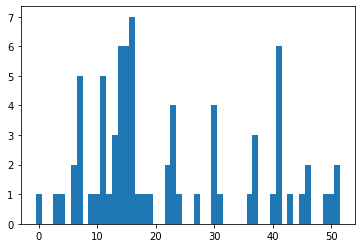

In [42]:
plt.hist(AllRelevant, bins = np.arange(-0.5,
                                       max(AllRelevant)+0.5,1))

### Transform back to original sectors

In [43]:
def ReverseDiag(Array, ZERO = False):
    N = np.sqrt(2*len(Array)+0.25)+0.5
    N = int(N)
    Original = np.ones(int(N**2.)).reshape(1,-1)
    
    if ZERO:
        Original = np.zeros(int(N**2.)).reshape(1,-1)
    
    index = np.triu(np.ones((N,N)),1)
    index = index.reshape(1,-1)
    index = index.astype(bool)
    
    Original[index] = Array # upper triangle
    Original = Original.reshape((N,N))
    Original = Original.T  # guarantee symmetry
    Original=Original.reshape(1,-1)
    Original[index] = Array
    Original=Original.reshape((N,N))

    return(Original)

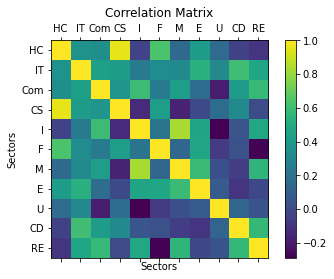

In [44]:
def plot_matrix(m, title='Correlation Matrix', cmap=plt.cm.Blues, labels=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(m)
    plt.title(title,y=1.08)
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Sectors')
    plt.ylabel('Sectors')
    plt.show()
    
plot_matrix(ReverseDiag(CorrMatrices[1,:]),
           labels = Names)

### Plot Relevances

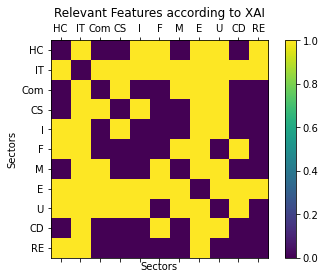

In [45]:
RelevantCombined = np.array(list(set(AllRelevant))).astype("int")
RelevancePlot = np.zeros(55)
RelevancePlot[RelevantCombined] = 1.
plot_matrix(ReverseDiag(RelevancePlot,
                       ZERO = True),
            title = "Relevant Features according to XAI",
           labels = Names)

In [46]:
def PrintNames(Mat, Names):
    Out = list()
    for i in range(Mat.shape[0]):
        for j in range(i+1, Mat.shape[1]):
            if Mat[i,j]==1:
                Out.append(Names[i]+"/"+Names[j])
    return(Out)
                

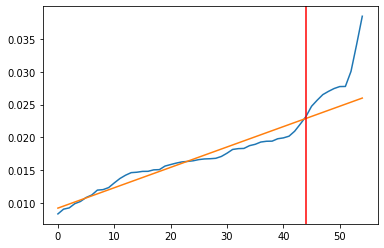

0 10 [23 15 14 51 43 19 16 41 11 30]


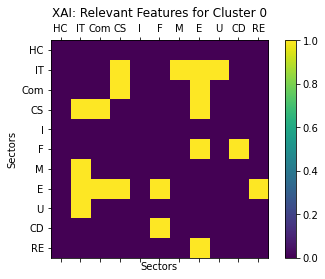

Relevant Correlations: ['IT/CS', 'IT/M', 'IT/E', 'IT/U', 'Com/CS', 'Com/E', 'CS/E', 'F/E', 'F/CD', 'E/RE']
 # # # # 


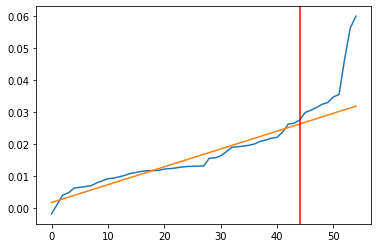

1 10 [31 16 46 45 37 41  9  4 40  7]


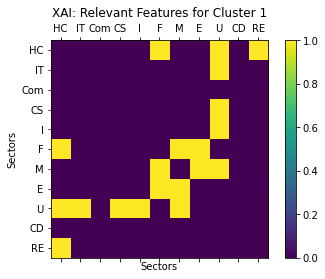

Relevant Correlations: ['HC/F', 'HC/U', 'HC/RE', 'IT/U', 'CS/U', 'I/U', 'F/M', 'F/E', 'M/E', 'M/U']
 # # # # 


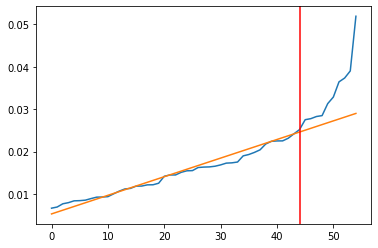

2 10 [49 15 14 30 52 41 46  7 37 16]


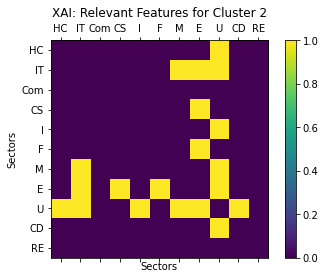

Relevant Correlations: ['HC/U', 'IT/M', 'IT/E', 'IT/U', 'CS/E', 'I/U', 'F/E', 'M/U', 'E/U', 'U/CD']
 # # # # 


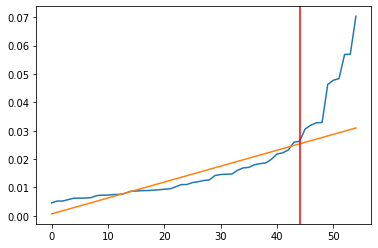

3 10 [11  7 51 50 15 23 30  6 36 41]


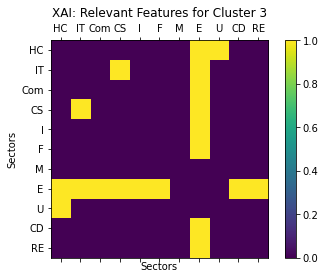

Relevant Correlations: ['HC/E', 'HC/U', 'IT/CS', 'IT/E', 'Com/E', 'CS/E', 'I/E', 'F/E', 'E/CD', 'E/RE']
 # # # # 


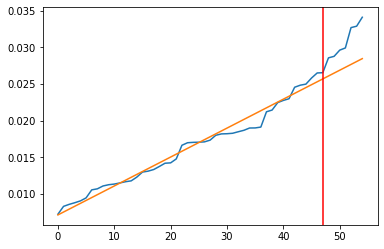

4 7 [27  3 11 14 37  7 16]


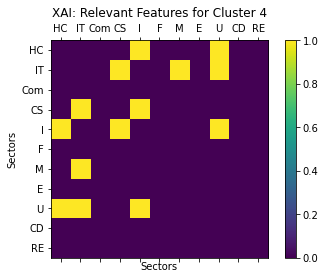

Relevant Correlations: ['HC/I', 'HC/U', 'IT/CS', 'IT/M', 'IT/U', 'CS/I', 'I/U']
 # # # # 


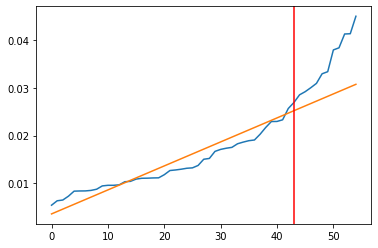

5 11 [13 11 41 22 30 24 23 14  7 15 16]


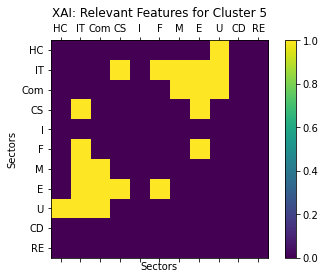

Relevant Correlations: ['HC/U', 'IT/CS', 'IT/F', 'IT/M', 'IT/E', 'IT/U', 'Com/M', 'Com/E', 'Com/U', 'CS/E', 'F/E']
 # # # # 


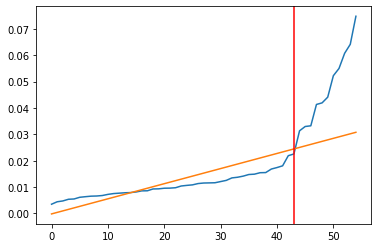

6 11 [10 15 18 22  0 17 11 16 13 12 14]


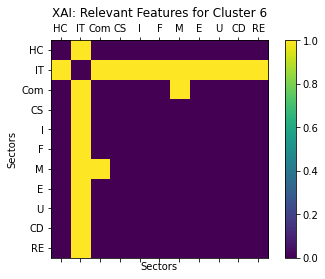

Relevant Correlations: ['HC/IT', 'IT/Com', 'IT/CS', 'IT/I', 'IT/F', 'IT/M', 'IT/E', 'IT/U', 'IT/CD', 'IT/RE', 'Com/M']
 # # # # 


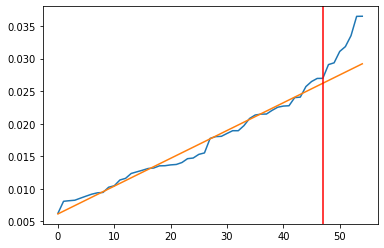

7 7 [ 6 13 23 41 14 16 15]


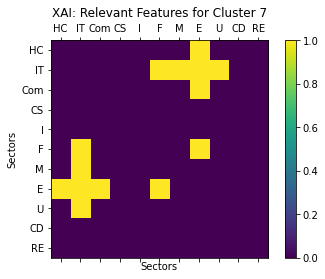

Relevant Correlations: ['HC/E', 'IT/F', 'IT/M', 'IT/E', 'IT/U', 'Com/E', 'F/E']
 # # # # 


In [47]:
# and plots for each Cluster
for j in range(nKM):
    #DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, True)
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, True)
    print(j, DE[0], DE[1] )
    
    relIndex = np.zeros(55)
    relIndex[DE[1]] = 1.
    RelMat = ReverseDiag(relIndex,
                       ZERO = True)
    plot_matrix(RelMat,
            title = "XAI: Relevant Features for Cluster "+str(j),
           labels = Names)
    print("Relevant Correlations:",PrintNames(RelMat, Names))
    
    print(" # # # # ")

In [48]:
np.save("XAI_Finance",XAI)